In [1]:
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

# importing all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import nltk
from nltk.corpus import stopwords
# from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

import time
from tqdm import tqdm

# ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# set Randomseed
RSEED = 42

# import needed functions
from modeling.processing import *

In [2]:
# load the first 100k lines of the review file into a dataframe

dfr = pd.read_csv('../data/yelp_dataset/review_1819.csv').iloc[0:200000]

In [3]:
# filter for only english reviews

dfr = language_processing(dfr, verbose=True)

In our Dataset we have a total of 1 different languages,
classified with an accuracy of at least 0.95.
------------------------------------------------------------------------------------------------------------------------------------------------------
These languages are (unsorted): 
{'Portuguese', 'Dutch', 'French', 'German', 'Spanish', 'Swedish', 'Chinese', 'Italian', 'English', 'Japanese'}
------------------------------------------------------------------------------------------------------------------------------------------------------
The classified languages represent 88.9 % of the dataset
------------------------------------------------------------------------------------------------------------------------------------------------------
The most occurring language is English, it occurred 177666 times
------------------------------------------------------------------------------------------------------------------------------------------------------
The algorithm was not able 

In [4]:
# initialize the stopword list:
stopwords = nltk.corpus.stopwords.words('english')

# update the stopwords after generating the first few clouds with non decisive words
#additional_stopwords = ['one', 'go', 'also', 'would', 'get', 'got']
#stopwords.extend(additional_stopwords)

In [5]:
# remove punctuation from the text in the initial df
dfr['text'] = dfr['text'].apply(remove_punctuation)

In [6]:
# split data into train and test set
train_set, test_set = train_test_split(pd.concat([dfr['text'], dfr['stars']], axis=1), random_state=RSEED) # concat…

In [7]:
# building mostly on (and partly copied from) https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
# documentation: https://radimrehurek.com/gensim/models/doc2vec.html
def tokenize(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for token in nltk.word_tokenize(sent):
            tokens.append(token)
    return tokens

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    # targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents]) # TODO check importance of "steps" argument
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

train_tagged = train_set.apply(lambda r:  TaggedDocument(words=tokenize(r.text), tags=[r.stars]), axis=1)
# d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample=0, workers=multiprocessing.cpu_count())
d2v = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, sample=0, workers=multiprocessing.cpu_count())
d2v.build_vocab([x for x in tqdm(train_tagged)])

# for epoch in range(30):
for epoch in range(10):
    d2v.train(utils.shuffle([x for x in tqdm(train_tagged)]), total_examples=len(train_tagged), epochs=1)
    d2v.alpha -= 0.002
    d2v.min_alpha = d2v.alpha

100%|██████████| 133249/133249 [00:00<00:00, 4296815.67it/s]


KeyboardInterrupt: 

In [ ]:
y_train, X_train = vec_for_learning(d2v, train_tagged)

test_tagged = test_set.apply(lambda r:  TaggedDocument(words=tokenize(r.text), tags=[r.stars]), axis=1)
y_test, X_test = vec_for_learning(d2v, test_tagged)

In [ ]:
# 
# # initialize the Classifier
# MNB = MultinomialNB()
# 
# # fit the model
# MNB.fit(X_train, y_train)
# 
# # make predictions
# y_pred = MNB.predict(X_test)
# 
# # test the model
# sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')
# 
# # show the classification report
# print(classification_report(y_pred, y_test))

In [ ]:
# # initialize the Classifier
# LSVC = LinearSVC()
# 
# # fit the model
# LSVC.fit(X_train, y_train)
# 
# # make predictions
# y_pred = LSVC.predict(X_test)
# 
# # test the model
# sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')
# 
# # show the classification report
# print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         3
         5.0       1.00      0.53      0.69      2178

    accuracy                           0.53      2182
   macro avg       0.20      0.11      0.14      2182
weighted avg       1.00      0.53      0.69      2182



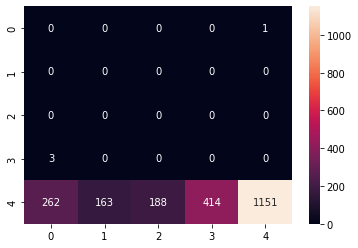

In [ ]:
# initialize the Classifier
logreg = LogisticRegression()

# fit the model
logreg.fit(X_train, y_train)    

# make predictions
y_pred = logreg.predict(X_test)

# test the model
sns.heatmap(confusion_matrix(y_pred, y_test), annot=True, fmt='g')

# show the classification report
print(classification_report(y_pred, y_test))